# Pixel Level Calibration

There are a lot of existing frameworks for phase retrieval - but it is not so straightforward to simultaneously retrieve 

- aberrations (the optical distortions, maybe tens of parameters)
- astrometry (the positions of stars, tens of parameters)
- interpixel sensitivity (aka the 'flat field', on a large pixel grid!)

The dimensionality of the pixel grid can be so high it is hard to retrieve without autodiff. With `dLux`, it is easy*!

\* This is the topic of a Desdoigts et al paper in prep. It wasn't quite that easy to build and we're pretty happy about it.

First, import everything as usual:

In [1]:
# Core jax
import jax
import jax.numpy as np
import jax.random as jr

# Optimisation
import equinox as eqx
import optax

# Optics
import dLux as dl

# Plotting/visualisation
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

%matplotlib inline
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "serif"
plt.rcParams['figure.dpi'] = 120

/Users/louis/mambaforge/envs/dlux/lib/python3.10/site-packages/chex/_src/pytypes.py:37: FutureWarning: jax.tree_structure is deprecated, and will be removed in a future release. Use jax.tree_util.tree_structure instead.
  PyTreeDef = type(jax.tree_structure(None))


Then we generate an array of 5 dithered images, in a coarsely-sampled broad bandwidth, of 15 stars. The reason we want multiple stars, and especially dithered images, is because we want to retrieve the _flat field_ - multiplicative errors on each pixel that, if we only have the one image, are formally degenerate with the PSF. It turns out that if we *can* hit each pixel with light from the same PSF multiple times, we can retrieve the whole thing unambiguously.

In [2]:
Nstars = 15
Nims = 5
Nwavels = 3

positions = jr.uniform(jr.PRNGKey(0), [Nstars, 2], minval=-1e-4, maxval=1e-4)
fluxes = 1e8 + 1e7*jr.normal(jr.PRNGKey(0), [Nstars])
wavels = 1e-9 * np.linspace(545, 645, Nwavels)
dithers = 1e-5 * np.array([[0,   0],
                           [+1, +1],
                           [+1, -1],
                           [-1, +1],
                           [-1, -1]])

We will use the presaved default Toliman pupil - a diffractive pupil that nicely spreads out the PSF in a highly structured pattern, designed (with `dLux`) to be ideal for astrometry and field calibration.

We will then add some Zernike mode aberrations on top of this, and have some 5% level flat field calibration errors, and additive background noise. 

In [3]:
# Base layers
lays = dl.utils.toliman_layers()
aperture = lays[2].array
wf_npix = aperture.shape[0]
det_npix = lays[-1].pixels_out

# Load mask
mask = np.load("files/test_mask.npy") * (wavels.mean()/(2*np.pi)) # tinytol pupil design

# Zernike Basis
zern_basis = dl.utils.zernike_basis(10, wf_npix, outside=0.)[3:]
coeffs = 2.5e-8 * jr.normal(jr.PRNGKey(0), [len(zern_basis)])

# Pixel response
pix_response = 1 + 0.05*jr.normal(jr.PRNGKey(0), [det_npix, det_npix])
det_layers = [dl.ApplyPixelResponse(pix_response)]

# Background noise
BG_noise = np.abs(5*jr.normal(jr.PRNGKey(0), [Nims, det_npix, det_npix]))

/Users/louis/mambaforge/envs/dlux/lib/python3.10/site-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=bool. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "


Turn these into an `OpticalSystem` object:

In [4]:
# Test Osys
layers = dl.utils.toliman_layers([
                dl.ApplyOPD(mask),
                dl.ApplyBasisOPD(zern_basis, coeffs)])

osys = dl.OpticalSystem(layers, 
                        wavels=wavels, 
                        positions=positions, 
                        fluxes=fluxes,
                        dithers=dithers,
                        detector_layers=det_layers)

Generate the dithered, noisy images:

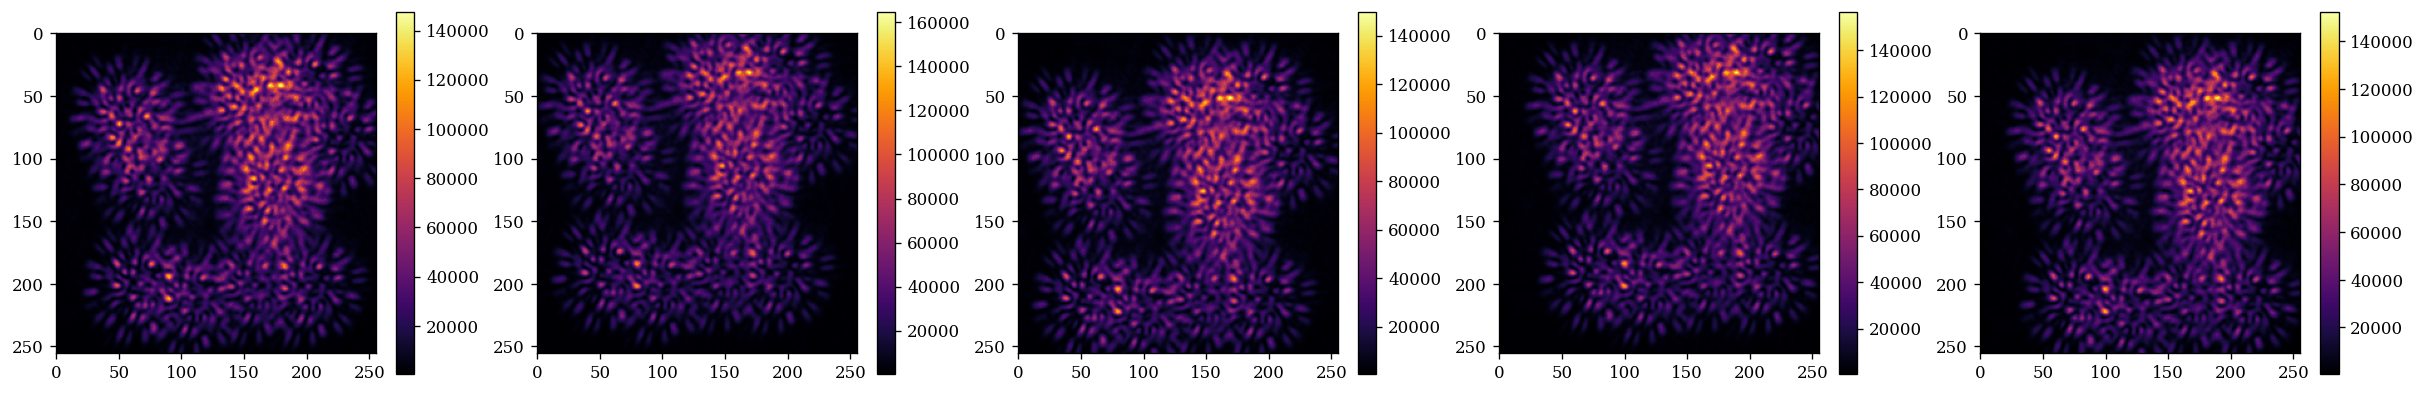

In [5]:
psfs = jr.poisson(jr.PRNGKey(0), osys.propagate()) + BG_noise
data = psfs

plt.figure(figsize=(25, 4))
for i in range(len(psfs)):
    plt.subplot(1, 5, i+1)
    plt.imshow(psfs[i])
    plt.colorbar()
plt.show()

Now there are 4 sets of parameters we are going to learn:
 - Positions
 - Fluxes
 - Zernike aberrations
 - Pixel responses
 
We start by defining the paths to those parameters. We will define them individually so we can refer to them easily later

In [6]:
pos_path = ['positions']
flux_path = ['fluxes']
coeff_path = ['layers', 5, 'coeffs']
pix_resp_path = ['detector_layers', 0, 'pixel_response']

paths = [pos_path,
         flux_path,
         coeff_path,
         pix_resp_path]

Each of these parameters needs a different initilisation
 - Positions need to be shifted by some random value
 - Fluxes need to be multiplied by some random value
 - Zernike coefficients need to be set to zero
 - Pixel response values need to be set to one
 
Now there are two ways we can do this. We can either shift, set, and perturb the values ourself, and update the optical system to have those new values (simpler), or we can define some functions to apply to those leaves and update the optical system that way (advanced). 

Lets show how to do both

In [7]:
# (simple)
# Set the new values manually
positions_init    = positions + 1e-7*jr.normal(jr.PRNGKey(0), positions.shape)
fluxes_init       = fluxes * (1 + 0.1*jr.normal(jr.PRNGKey(0), fluxes.shape))
coeffs_init       = np.zeros(coeffs.shape)
pix_response_init = np.ones(pix_response.shape)

# Combine into a list
values = [positions_init, 
          fluxes_init, 
          coeffs_init,
          pix_response_init]

# Generate the new optical system
model = osys.update_leaves(paths, values)

In [8]:
# (advanced)
# Define functions to apply to apply to the leaves
perturb_pos =    lambda pos: pos + 1e-7*jr.normal(jr.PRNGKey(0), pos.shape)
perturb_fluxes = lambda fluxes: fluxes * (1 + 0.1*jr.normal(jr.PRNGKey(0), fluxes.shape))
set_zero =       lambda leaf: leaf*0
set_one =        lambda leaf: leaf/leaf

# Combine into list
perturb_fns = [perturb_pos, 
               perturb_fluxes, 
               set_zero,
               set_one]

# Generate new optical system
model = osys.apply_to_leaves(paths, perturb_fns)

The residuals are pretty bad:

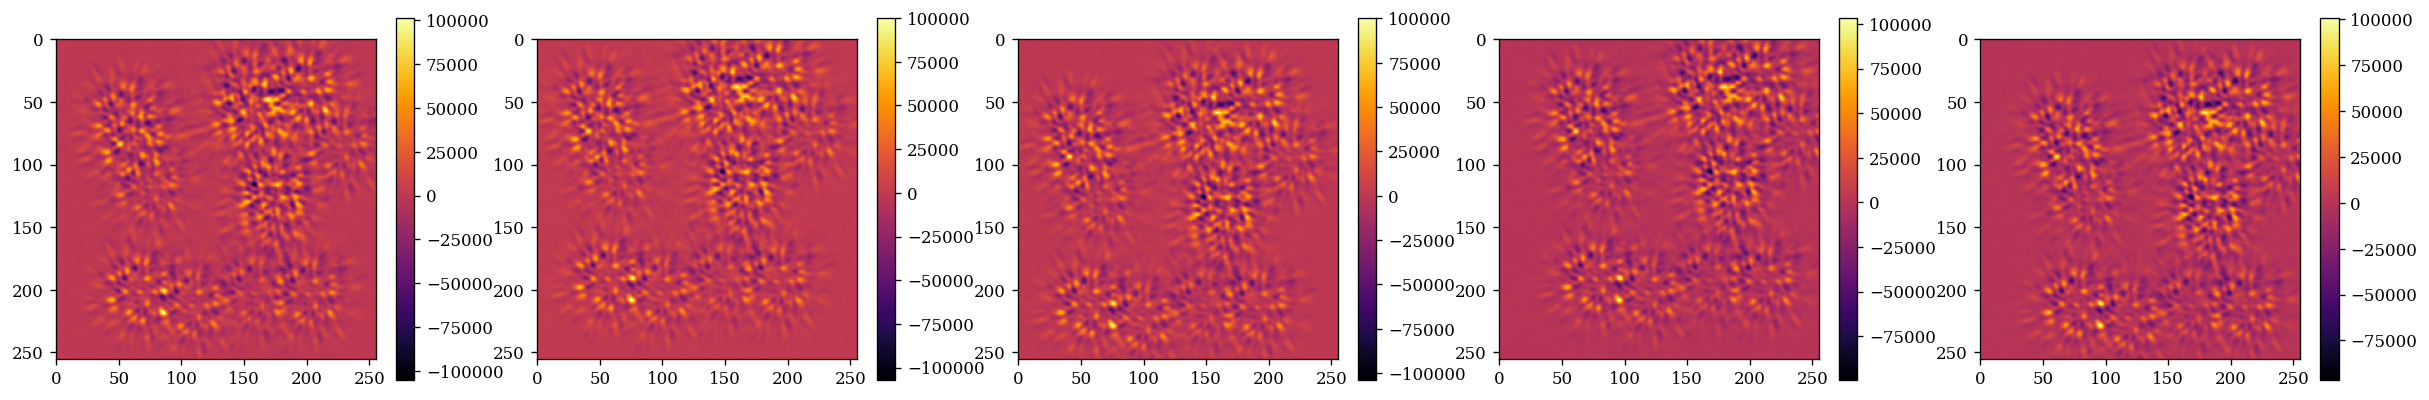

In [9]:
psfs = model.propagate()

plt.figure(figsize=(25, 4))
for i in range(len(psfs)):
    plt.subplot(1, 5, i+1)
    plt.imshow(psfs[i] - data[i])
    plt.colorbar()
plt.show()

Now we want to generate an optax optimiser object that we can use to train each parameter individually. Becuase of the various scales and effect of the loss fucntion that each parameter has, we need to be able to set individual learning rates, and optimisation schedules for every parameter. Luckily we have built some functions to help specifically with that! Lets see how to use it!

In [10]:
# So first we simply set the simple parameters to use an adam optimiser 
# algorithm, with individual learning rates
pos_optimiser   = optax.adam(2e-8)
flux_optimiser  = optax.adam(1e6)
coeff_optimiser = optax.adam(2e-9)

# Now the flat-field is more complex, becuase it is highly covariant with 
# the mean flux level, we need to let the rest of the system get close to 
# the right solution before we start to learn the flat field values.
# The optax schedule lets us do this. Please read the optax docs for details,
# but in short we are turning the flat field learning rate functionally to 
# zero for the first 100 epochs, and then setting it to its true value
FF_sched = optax.piecewise_constant_schedule(init_value=1e-2*1e-8, 
                             boundaries_and_scales={100 : int(1e8)})
FF_optimiser = optax.adam(FF_sched)

# Combine the optimisers into a list
optimisers = [pos_optimiser, flux_optimiser, coeff_optimiser, FF_optimiser]

# Generate out optax optimiser, and also get our filter spec
optim, filter_spec = model.get_optimiser(paths, optimisers, get_filter_spec=True)
opt_state = optim.init(model)

Poisson log-likelihood:

In [11]:
@eqx.filter_jit
@eqx.filter_value_and_grad(arg=filter_spec)
def loss_func(model, data):
    out = model.propagate()
    return -np.sum(jax.scipy.stats.poisson.logpmf(data, out))

Call once to jit compile:

In [12]:
%%time
loss, grads = loss_func(model, data) # Compile

print("Initial Loss: {}".format(int(loss)))

Initial Loss: 940528320
CPU times: user 4.15 s, sys: 181 ms, total: 4.34 s
Wall time: 1.44 s


Initialize `optax` optimizer:

Run gradient descent:

In [13]:
errors, grads_out, models_out = [], [], []
with tqdm(range(200),desc='Gradient Descent') as t:
    for i in t: 
        loss, grads = loss_func(model, data)    

        updates, opt_state = optim.update(grads, opt_state)
        model = eqx.apply_updates(model, updates)
        errors.append(loss)
        grads_out.append(grads)
        models_out.append(model)
    
        t.set_description("Log Loss: {:.3f}".format(np.log10(loss))) # update the progress bar

Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

Format the output into arrays:

In [14]:
nepochs = len(models_out)
psfs_out = models_out[-1].propagate()

positions_found = np.array([model.get_leaf(pos_path)      for model in models_out])
fluxes_found =    np.array([model.get_leaf(flux_path)     for model in models_out])
coeffs_found =    np.array([model.get_leaf(coeff_path)    for model in models_out])
prs_found =       np.array([model.get_leaf(pix_resp_path) for model in models_out])

Pull out the quantities to be plotted - eg final model and residuals:

In [15]:
final_model = models_out[-1]
errors = np.array(errors)

coeff_residuals = coeffs - coeffs_found
flux_residuals = fluxes - fluxes_found

scaler = 1e3
positions_residuals = positions - positions_found
r_residuals_rads = np.hypot(positions_residuals[:, :, 0], positions_residuals[:, :, 1])
r_residuals = dl.utils.rad2arcsec(r_residuals_rads)

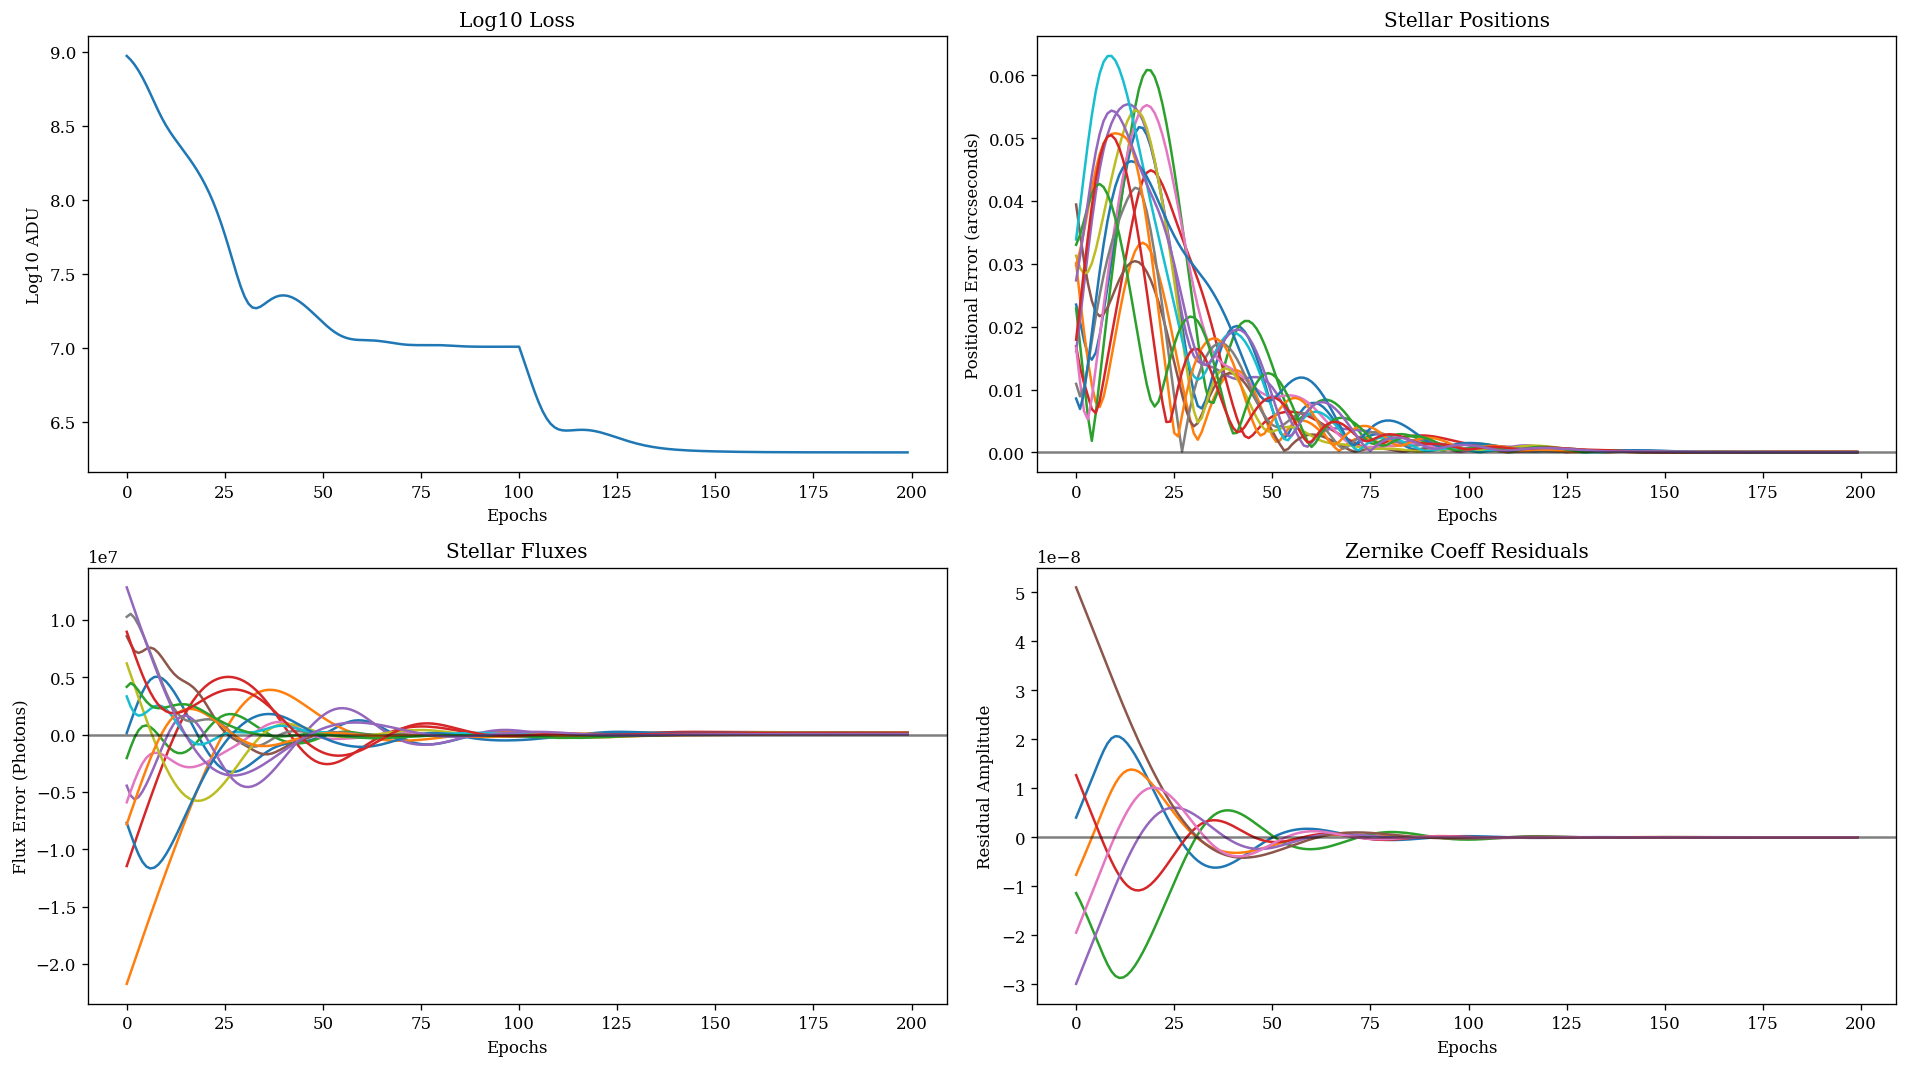

In [16]:
j = len(models_out)
plt.figure(figsize=(16, 13))

plt.subplot(3, 2, 1)
plt.title("Log10 Loss")
plt.xlabel("Epochs")
plt.ylabel("Log10 ADU")
plt.plot(np.log10(errors[:j]))

plt.subplot(3, 2, 2)
plt.title("Stellar Positions")
plt.xlabel("Epochs")
plt.ylabel("Positional Error (arcseconds)")
plt.plot(r_residuals[:j])
plt.axhline(0, c='k', alpha=0.5)

plt.subplot(3, 2, 3)
plt.title("Stellar Fluxes")
plt.xlabel("Epochs")
plt.ylabel("Flux Error (Photons)")
plt.plot(flux_residuals[:j])
plt.axhline(0, c='k', alpha=0.5)

plt.subplot(3, 2, 4)
plt.title("Zernike Coeff Residuals")
plt.xlabel("Epochs")
plt.ylabel("Residual Amplitude")
plt.plot(coeff_residuals[:j])
plt.axhline(0, c='k', alpha=0.5)

plt.tight_layout()
plt.show()

How did the phase retrieval go? Really well, as it happens!

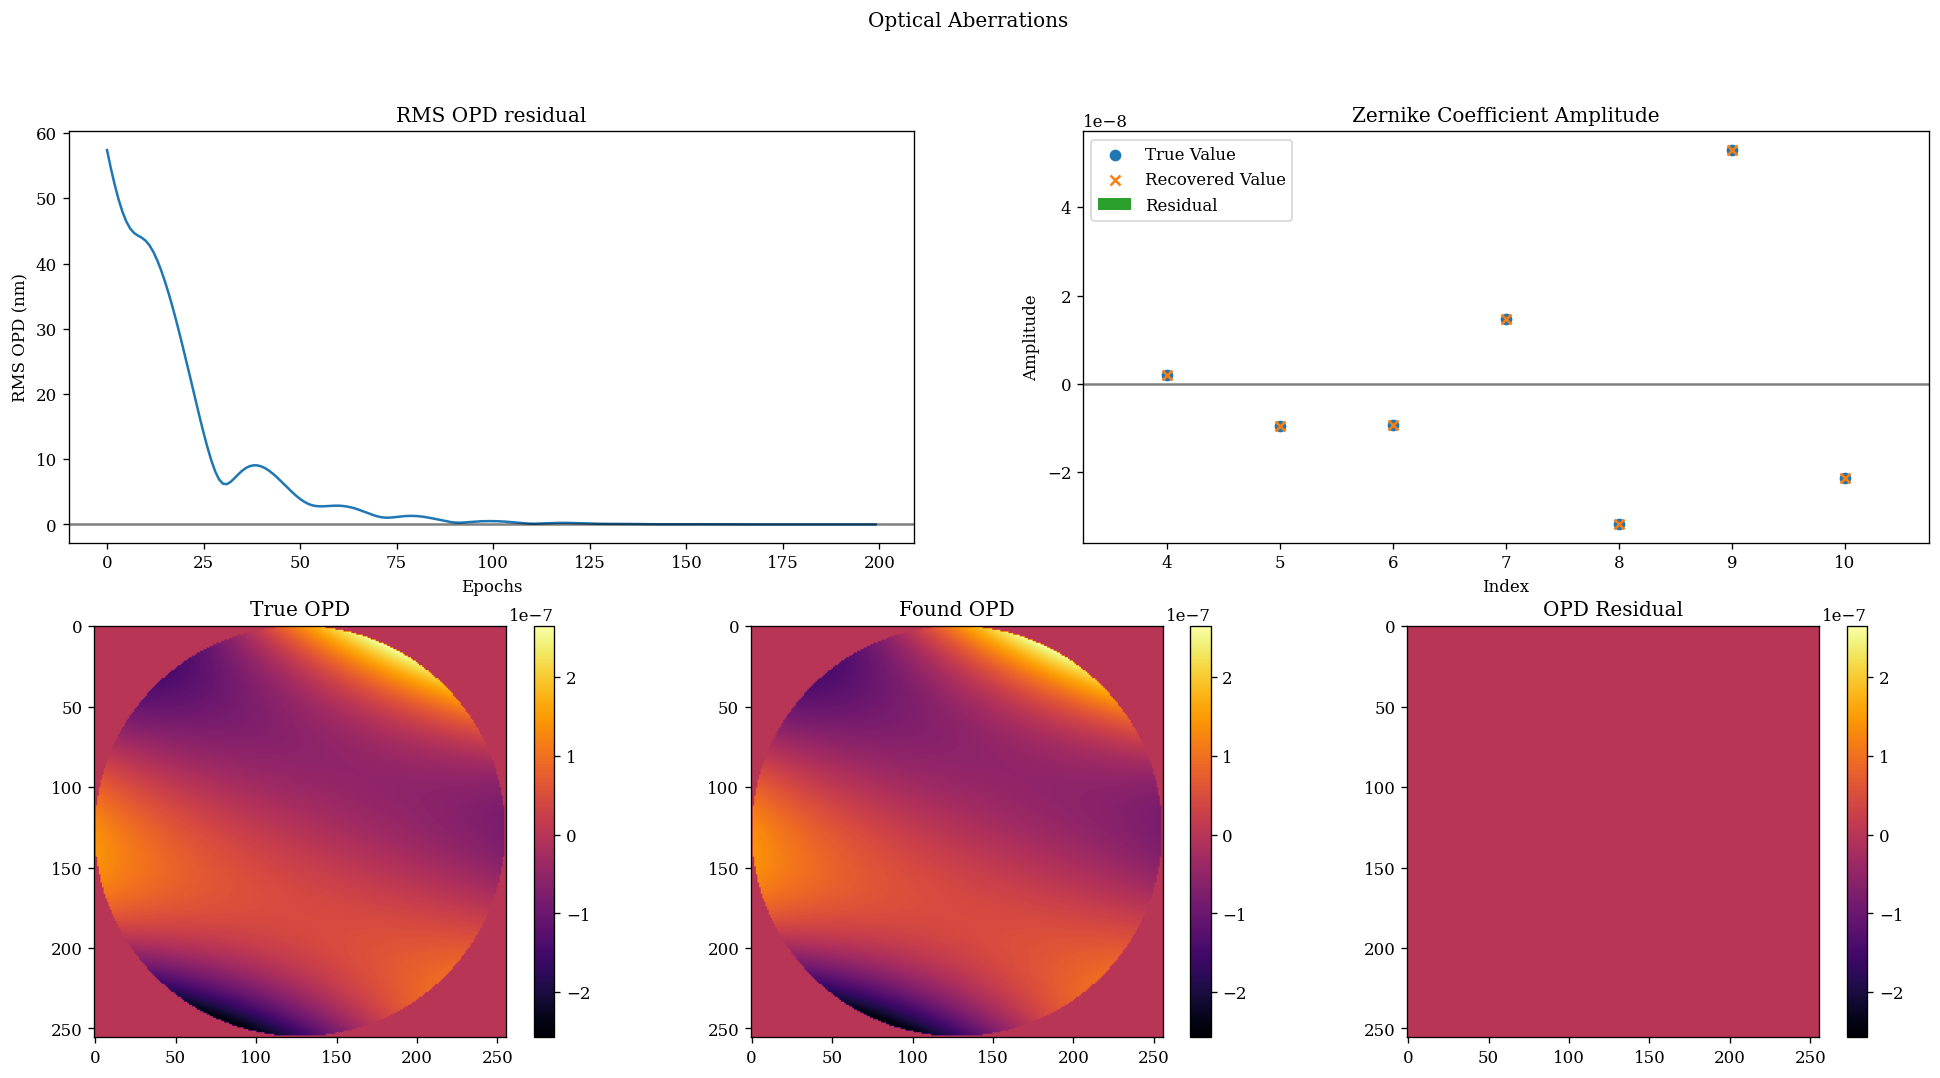

In [17]:
# OPDs
true_opd = osys.layers[-2].get_total_opd()
opds_found = np.array([model.layers[-2].get_total_opd() for model in models_out])
found_opd = opds_found[-1]
opd_residuls = true_opd - opds_found
opd_rmse_nm = 1e9*np.mean(opd_residuls**2, axis=(-1,-2))**0.5

vmin = np.min(np.array([true_opd, found_opd]))
vmax = np.max(np.array([true_opd, found_opd]))

# Coefficients
true_coeff = osys.layers[-2].coeffs
found_coeff = final_model.layers[-2].coeffs
index = np.arange(len(true_coeff))+4

plt.figure(figsize=(20, 10))
plt.suptitle("Optical Aberrations")

plt.subplot(2, 2, 1)
plt.title("RMS OPD residual")
plt.xlabel("Epochs")
plt.ylabel("RMS OPD (nm)")
plt.plot(opd_rmse_nm)
plt.axhline(0, c='k', alpha=0.5)

plt.subplot(2, 2, 2)
plt.title("Zernike Coefficient Amplitude")
plt.xlabel("Index")
plt.ylabel("Amplitude")
plt.scatter(index, true_coeff, label="True Value")
plt.scatter(index, found_coeff, label="Recovered Value", marker='x')
plt.bar(index, true_coeff - found_coeff, label='Residual')
plt.axhline(0, c='k', alpha=0.5)
plt.legend()

plt.subplot(2, 3, 4)
plt.title("True OPD")
plt.imshow(true_opd)
plt.colorbar()

plt.subplot(2, 3, 5)
plt.title("Found OPD")
plt.imshow(found_opd)
plt.colorbar()

plt.subplot(2, 3, 6)
plt.title("OPD Residual")
plt.imshow(true_opd - found_opd, vmin=vmin, vmax=vmax)
plt.colorbar()
plt.show()

Most impressively, we are getting the tens of thousands of parameters of the flat field pretty well too!

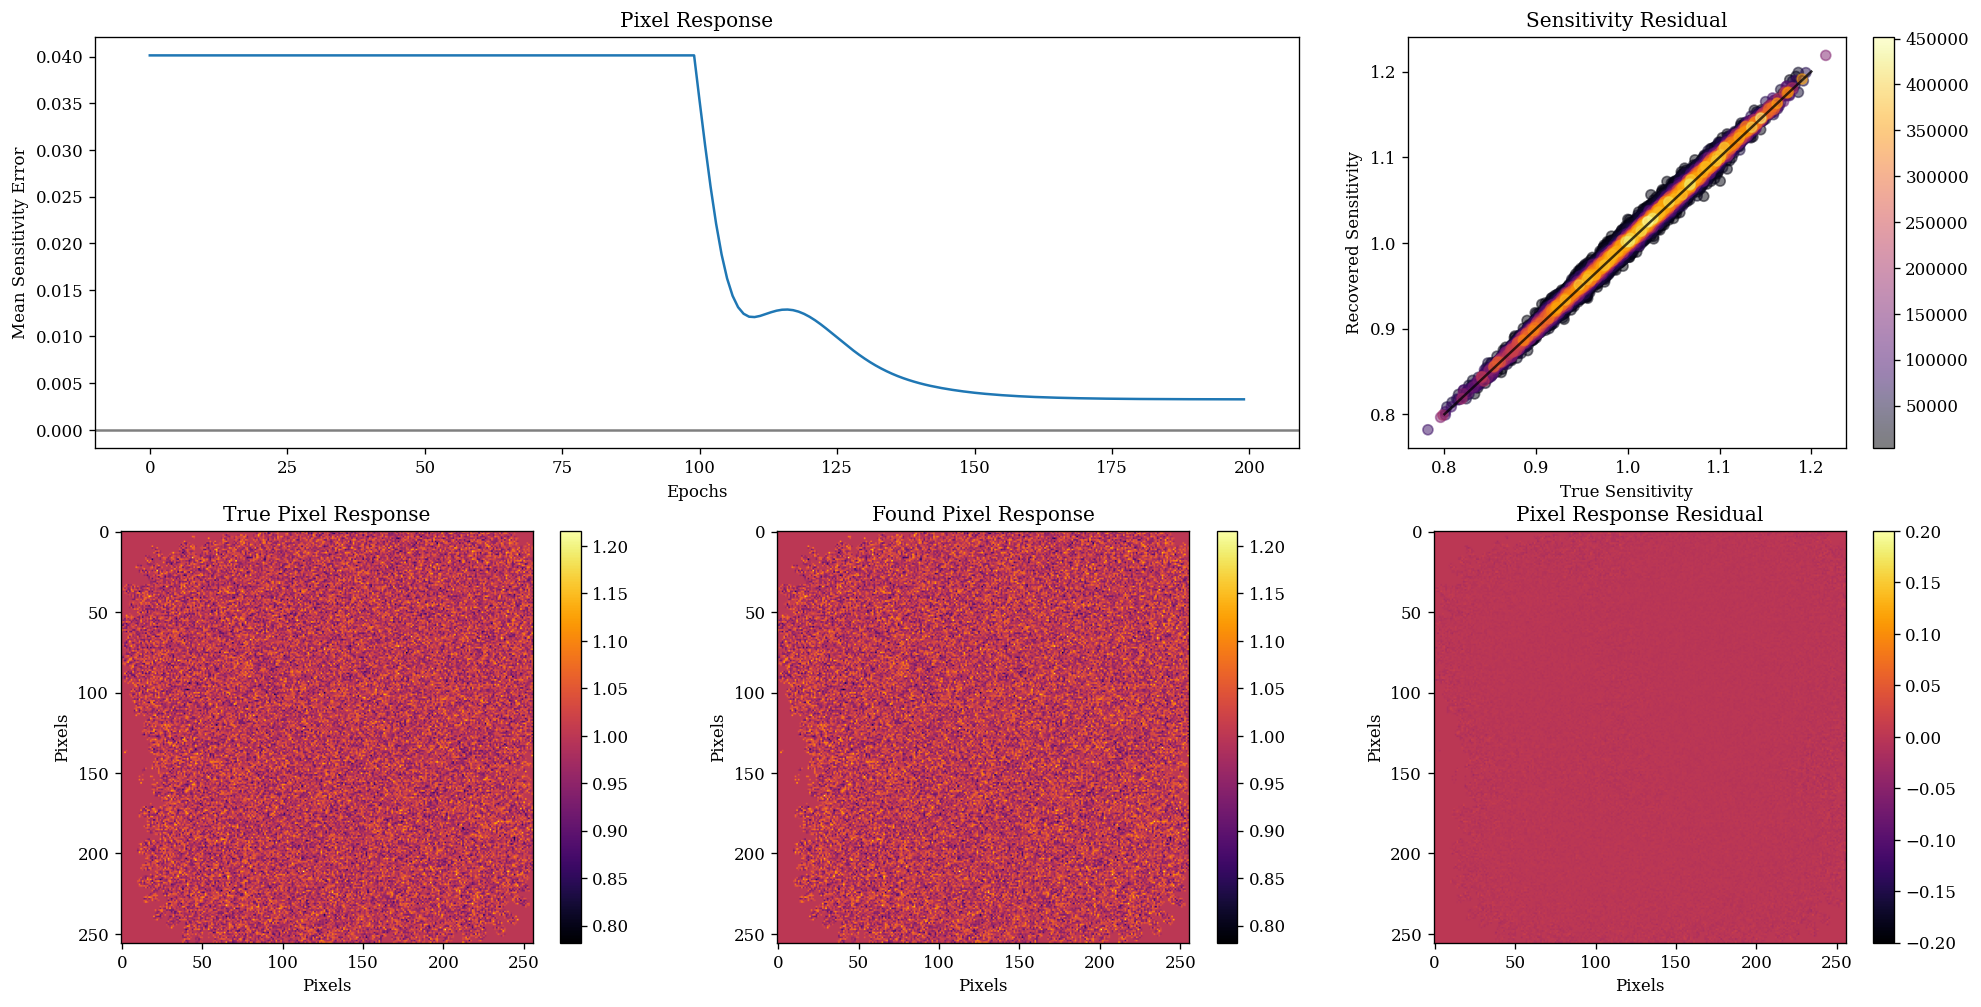

In [18]:
# calculate the mask where there was enough flux to infer the flat field
thresh = 2500
fmask = data.mean(0) >= thresh

out_mask = np.where(data.mean(0) < thresh)
in_mask = np.where(data.mean(0) >= thresh)

data_tile = np.tile(data.mean(0), [len(models_out), 1, 1])
in_mask_tiled = np.where(data_tile >= thresh)

# calculate residuals
pr_residuals = pix_response[in_mask] - prs_found[-1][in_mask]

# for correlation plot
true_pr_masked = pix_response.at[out_mask].set(1)
found_pr_masked = prs_found[-1].at[out_mask].set(1)

# FF Scatter Plot
data_sum = data.sum(0) # [flux_mask]
colours = data_sum.flatten()
ind = np.argsort(colours)
colours = colours[ind]

pr_true_flat = true_pr_masked.flatten()
pr_found_flat = found_pr_masked.flatten()

pr_true_sort = pr_true_flat[ind]
pr_found_sort = pr_found_flat[ind]

# Errors
pfound = prs_found[in_mask_tiled].reshape([len(models_out), len(in_mask[0])])
ptrue = pix_response[in_mask]
pr_res = ptrue - pfound
masked_error = np.abs(pr_res).mean(-1)

plt.figure(figsize=(20, 10))
plt.subplot(2, 3, (1,2))
plt.title("Pixel Response")
plt.xlabel("Epochs")
plt.ylabel("Mean Sensitivity Error")
plt.plot(masked_error)
plt.axhline(0, c='k', alpha=0.5)

# FF Scatter Plot
data_sum = data.sum(0)
colours = data_sum.flatten()
ind = np.argsort(colours)
colours = colours[ind]

pr_true_flat = true_pr_masked.flatten()
pr_found_flat = found_pr_masked.flatten()

pr_true_sort = pr_true_flat[ind]
pr_found_sort = pr_found_flat[ind]

plt.subplot(2, 3, 3)
plt.plot(np.linspace(0.8, 1.2), np.linspace(0.8, 1.2), c='k', alpha=0.75)
plt.scatter(pr_true_sort, pr_found_sort, c=colours, alpha=0.5)
plt.colorbar()
plt.title("Sensitivity Residual")
plt.ylabel("Recovered Sensitivity")
plt.xlabel("True Sensitivity")

plt.subplot(2, 3, 4)
plt.title("True Pixel Response")
plt.xlabel("Pixels")
plt.ylabel("Pixels")
plt.imshow(true_pr_masked)
plt.colorbar()

vmin = np.min(pix_response)
vmax = np.max(pix_response)

plt.subplot(2, 3, 5)
plt.title("Found Pixel Response")
plt.xlabel("Pixels")
plt.ylabel("Pixels")
plt.imshow(found_pr_masked, vmin=vmin, vmax=vmax)
plt.colorbar()

plt.subplot(2, 3, 6)
plt.title("Pixel Response Residual")
plt.xlabel("Pixels")
plt.ylabel("Pixels")
plt.imshow(true_pr_masked - found_pr_masked, vmin=-0.2, vmax=0.2)
plt.colorbar()

plt.show()